Implement a Gaze-LLE to keep track of who is looking at who

In [3]:
%pip install timm
%pip install RetinaFace

Note: you may need to restart the kernel to use updated packages.
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl.metadata (2.0 kB)
Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
optree 0.13.1 requires typing-extensions>=4.5.0, but you have typing-extensions 3.7.4.3 which is incompatible.
tf-keras 2.16.0 requires tensorflow<2.17,>=2.16, but you have tensorflow 2.5.0 which is incompatible.
torch 2.2.2 requires typing-extensions>=4.8.0, but you have typing-extensions 3.7.4.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install torch

  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.12.2 which is incompatible.
tf-keras 2.16.0 requires tensorflow<2.17,>=2.16, but you have tensorflow 2.5.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch

# load Gaze-LLE model
model, transform = torch.hub.load('fkryan/gazelle', 'gazelle_dinov2_vitl14_inout')

model.eval()
model.to('cpu')

Using cache found in /Users/rgopalam/.cache/torch/hub/fkryan_gazelle_main
Using cache found in /Users/rgopalam/.cache/torch/hub/facebookresearch_dinov2_main


GazeLLE(
  (backbone): DinoV2Backbone(
    (model): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-23): 24 x NestedTensorBlock(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=4096, out_features=10

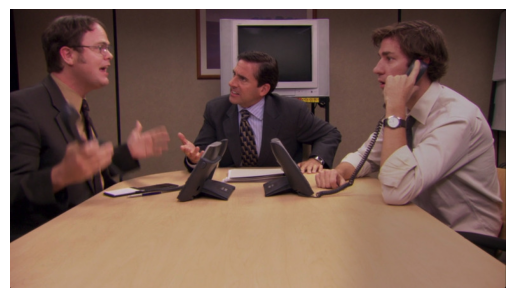

In [6]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO
import numpy as np

# load an input image

image_url = "https://www.looper.com/img/gallery/the-office-funniest-moments-ranked/jim-and-dwights-customer-service-training-1627594561.jpg"
# image_url = "https://ew.com/thmb/n5b8Asz4Y5Lp0sSEF7WgS-ESyFc=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/succession-finale-052923-ec304aabcbf24a7b9fad891a87f49b74.jpg"
# image_url = "https://i.kym-cdn.com/entries/icons/original/000/045/575/blackcatzoningout_meme.jpg"

try:
    response = requests.get(image_url, stream=True)
    response.raise_for_status()

    image = Image.open(BytesIO(response.content))
    width, height = image.size

    plt.imshow(image)
    plt.axis('off')
    plt.show()

except requests.exceptions.RequestException as e:
    print(f"Error downloading image: {e}")

Loading Gaze-LLE model...


Using cache found in /Users/rgopalam/.cache/torch/hub/fkryan_gazelle_main
Using cache found in /Users/rgopalam/.cache/torch/hub/facebookresearch_dinov2_main


Model and transform loaded successfully.


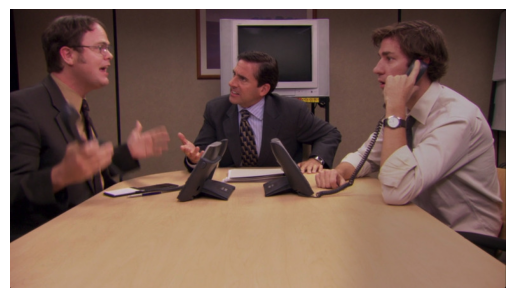

Bounding Boxes: [[101, 31, 180, 110], [532, 41, 627, 136], [348, 148, 403, 203], [456, 240, 488, 272]]


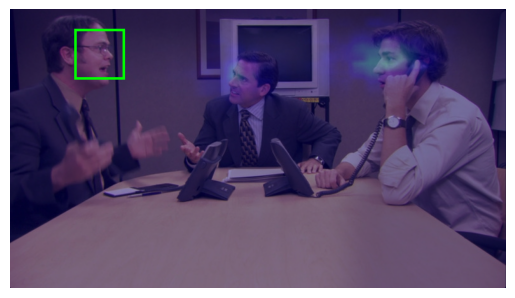

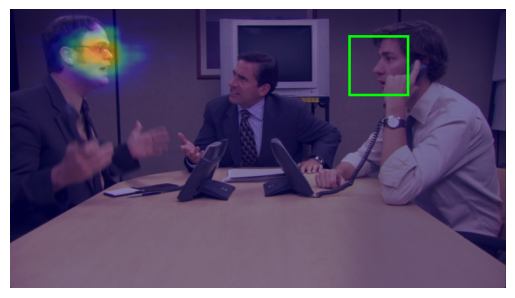

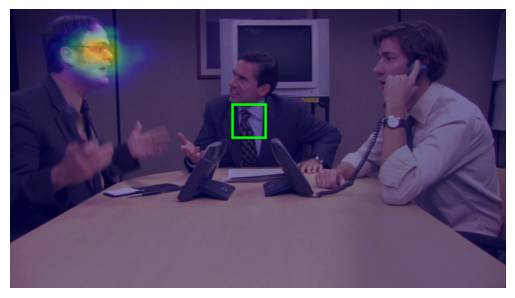

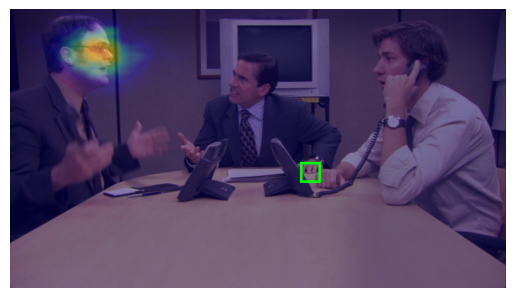

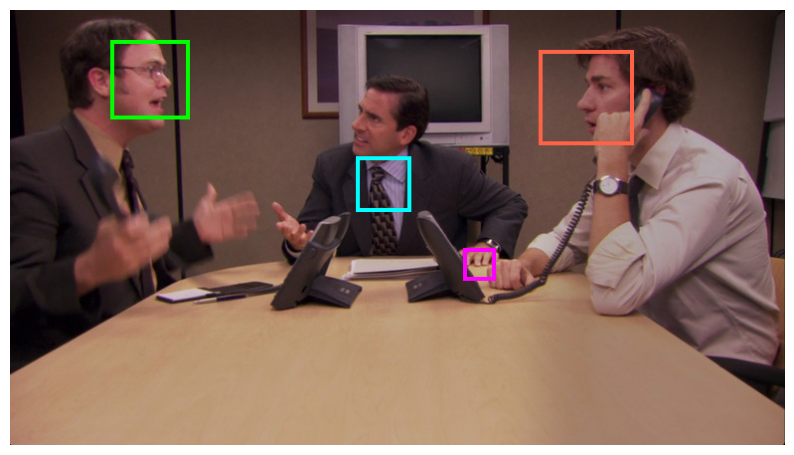

In [14]:
import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import torchvision.transforms as T
import requests
from io import BytesIO
import cv2

# Configuration constants for CascadeClassifier
CASCADE_PATH = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
SCALE_FACTOR = 1.1
MIN_NEIGHBORS = 5
MIN_FACE_SIZE = (30, 30)

# Function to initialize the Gaze-LLE model and transform
def initialize_gaze_model():
    print("Loading Gaze-LLE model...")
    model, _ = torch.hub.load('fkryan/gazelle', 'gazelle_dinov2_vitb14', trust_repo=True)
    model.eval()  # Set the model to evaluation mode
    # Define transform for preprocessing
    transform = T.Compose([
        T.Resize((448, 448)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    print("Model and transform loaded successfully.")
    return model, transform

# Detect faces using OpenCV's CascadeClassifier
def detect_faces_with_opencv(image):
    """Detect faces and get bounding boxes using OpenCV."""
    face_cascade = cv2.CascadeClassifier(CASCADE_PATH)
    frame = np.array(image)  # Convert PIL image to numpy array
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(
        gray_frame,
        scaleFactor=1.01,  # Reduce for more sensitivity
        minNeighbors=3,    # Lower for more detections
        minSize=(20, 20)   # Smaller minimum face size
    )
    bboxes = [[x, y, x + w, y + h] for (x, y, w, h) in faces]  # Convert to [x1, y1, x2, y2]
    return bboxes


# Visualization functions
def visualize_heatmap(pil_image, heatmap, bbox=None, inout_score=None):
    if isinstance(heatmap, torch.Tensor):
        heatmap = heatmap.detach().cpu().numpy()
    heatmap = Image.fromarray((heatmap * 255).astype(np.uint8)).resize(pil_image.size, Image.Resampling.BILINEAR)
    heatmap = plt.cm.jet(np.array(heatmap) / 255.)
    heatmap = (heatmap[:, :, :3] * 255).astype(np.uint8)
    heatmap = Image.fromarray(heatmap).convert("RGBA")
    heatmap.putalpha(90)
    overlay_image = Image.alpha_composite(pil_image.convert("RGBA"), heatmap)

    if bbox is not None:
        width, height = pil_image.size
        xmin, ymin, xmax, ymax = bbox
        draw = ImageDraw.Draw(overlay_image)
        draw.rectangle([xmin * width, ymin * height, xmax * width, ymax * height], outline="lime", width=int(min(width, height) * 0.01))

        if inout_score is not None:
            text = f"in-frame: {inout_score:.2f}"
            draw.text((xmin * width, ymax * height + 10), text, fill="lime")
    return overlay_image

def visualize_all(pil_image, heatmaps, bboxes, inout_scores, inout_thresh=0.5):
    colors = ['lime', 'tomato', 'cyan', 'fuchsia', 'yellow']
    overlay_image = pil_image.convert("RGBA")
    draw = ImageDraw.Draw(overlay_image)
    width, height = pil_image.size

    for i in range(len(bboxes)):
        bbox = bboxes[i]
        xmin, ymin, xmax, ymax = bbox
        color = colors[i % len(colors)]
        draw.rectangle([xmin * width, ymin * height, xmax * width, ymax * height], outline=color, width=int(min(width, height) * 0.01))

        if inout_scores is not None:
            inout_score = inout_scores[i]
            text = f"in-frame: {inout_score:.2f}"
            draw.text((xmin * width, ymax * height + 10), text, fill=color)

        if inout_scores is not None and inout_score > inout_thresh:
            heatmap = heatmaps[i]
            heatmap_np = heatmap.detach().cpu().numpy()
            max_index = np.unravel_index(np.argmax(heatmap_np), heatmap_np.shape)
            gaze_target_x = max_index[1] / heatmap_np.shape[1] * width
            gaze_target_y = max_index[0] / heatmap_np.shape[0] * height
            bbox_center_x = ((xmin + xmax) / 2) * width
            bbox_center_y = ((ymin + ymax) / 2) * height

            draw.ellipse([(gaze_target_x-5, gaze_target_y-5), (gaze_target_x+5, gaze_target_y+5)], fill=color)
            draw.line([(bbox_center_x, bbox_center_y), (gaze_target_x, gaze_target_y)], fill=color)

    return overlay_image

# Main pipeline
def main():
    # Initialize the model and transform
    model, transform = initialize_gaze_model()

    # Load a test image
    image_url = "https://www.looper.com/img/gallery/the-office-funniest-moments-ranked/jim-and-dwights-customer-service-training-1627594561.jpg"
    try:
        response = requests.get(image_url, stream=True)
        response.raise_for_status()

        image = Image.open(BytesIO(response.content)).convert("RGB")
        width, height = image.size

        plt.imshow(image)
        plt.axis('off')
        plt.show()

    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
        return

    # Detect faces using OpenCV
    bboxes = detect_faces_with_opencv(image)  # Use OpenCV for face detection
    print("Bounding Boxes:", bboxes)

    if not bboxes:
        print("No faces detected in the image.")
        return

    # Prepare Gaze-LLE input
    img_tensor = transform(image).unsqueeze(0).to("cpu")
    norm_bboxes = [[np.array(bbox) / np.array([width, height, width, height]) for bbox in bboxes]]

    input_data = {
        "images": img_tensor,
        "bboxes": norm_bboxes
    }

    with torch.no_grad():
        output = model(input_data)

    # Visualize results
    for i in range(len(bboxes)):
        plt.figure()
        plt.imshow(visualize_heatmap(image, output['heatmap'][0][i], norm_bboxes[0][i], inout_score=output['inout'][0][i] if output['inout'] is not None else None))
        plt.axis('off')
        plt.show()

    # Combined visualization
    plt.figure(figsize=(10, 10))
    plt.imshow(visualize_all(image, output['heatmap'][0], norm_bboxes[0], output['inout'][0] if output['inout'] is not None else None, inout_thresh=0.5))
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()


In [4]:

import cv2
import torch
import numpy as np
from PIL import Image
from retinaface import RetinaFace
from yt_dlp import YoutubeDL
import matplotlib.pyplot as plt

# Function to fetch video URL using yt-dlp
def get_video_url(youtube_url):
    ydl_opts = {'quiet': True, 'format': 'best[ext=mp4]'}
    with YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(youtube_url, download=False)
        return info['url']

# Function to visualize the gaze heatmap and gaze target
def visualize_gaze(frame, heatmap, bbox):
    height, width, _ = frame.shape
    x1, y1, x2, y2 = bbox

    # Scale heatmap to image size
    heatmap_resized = cv2.resize(heatmap.cpu().numpy(), (width, height))
    heatmap_overlay = (heatmap_resized * 255).astype(np.uint8)
    heatmap_colored = cv2.applyColorMap(heatmap_overlay, cv2.COLORMAP_JET)

    # Add transparency to heatmap
    overlay = cv2.addWeighted(frame, 0.7, heatmap_colored, 0.3, 0)

    # Draw bounding box
    cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Find gaze target (highest probability in heatmap)
    max_idx = np.unravel_index(np.argmax(heatmap_resized), heatmap_resized.shape)
    gaze_x, gaze_y = max_idx[1], max_idx[0]
    cv2.circle(overlay, (gaze_x, gaze_y), radius=5, color=(255, 0, 0), thickness=-1)
    cv2.line(overlay, ((x1 + x2) // 2, (y1 + y2) // 2), (gaze_x, gaze_y), (0, 255, 255), 2)

    return overlay

# Add a frame skip interval
FRAME_SKIP = 20  # Process every 5th frame

# Process YouTube live stream
youtube_url = "https://www.youtube.com/watch?v=96Y6mc3C1Bg"  # Replace with your URL
video_url = get_video_url(youtube_url)
cap = cv2.VideoCapture(video_url)

if not cap.isOpened():
    print("Error: Unable to open the YouTube video stream.")
else:
    print("Processing YouTube video. Press 'q' to quit.")
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            print("End of video or error reading the video stream.")
            break

        # Skip frames
        if frame_count % FRAME_SKIP != 0:
            frame_count += 1
            continue

        # Face detection with RetinaFace
        detections = RetinaFace.detect_faces(frame)
        if detections:
            bounding_boxes = [detections[key]["facial_area"] for key in detections.keys()]

            # Prepare Gaze-LLE inputs
            pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            input_tensor = transform(pil_image).unsqueeze(0)
            norm_bboxes = [[np.array(bbox) / np.array([frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]]) for bbox in bounding_boxes]]

            input_data = {
                "images": input_tensor,
                "bboxes": norm_bboxes
            }

            # Predict gaze heatmaps
            with torch.no_grad():
                output = model(input_data)

            # Visualize results
            for i, bbox in enumerate(bounding_boxes):
                heatmap = output["heatmap"][0][i]
                frame = visualize_gaze(frame, heatmap, bbox)

        # Display frame with gaze visualization
        cv2.imshow("Gaze-LLE on YouTube Live Stream", frame)

        # Exit on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("Exiting video processing.")
            break

        frame_count += 1

cap.release()
cv2.destroyAllWindows()


Processing YouTube video. Press 'q' to quit.


AttributeError: type object 'RetinaFace' has no attribute 'detect_faces'